<a href="https://colab.research.google.com/github/abdipourasl/Deep-Learning-1402/blob/main/DL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-block alert-success">
<h1>Deep Learning Project #2<h1>
Amin Abdipour</h1>
</div>

#  ***Question 1***

### Importing Libraries

In [3]:
import numpy as np
import torch
import pandas as pd
import os
import os.path as op
import sklearn
import matplotlib.pyplot as plt
from google.colab import drive
import cv2
drive.mount('/content/drive')
from google.colab.patches import cv2_imshow
from PIL import Image
from torch.utils.data import random_split, DataLoader
import torch.nn as nn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. Import  Data

data type:  <class 'PIL.JpegImagePlugin.JpegImageFile'>


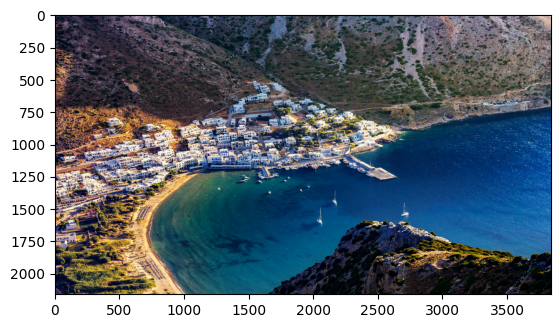

In [4]:
dir = op.join('/content/drive/My Drive/','DL','sifnos-greece-3840x2160-12799.jpg')  # Path to the Data folder
img = Image.open(dir)
print('data type: ', type(img))
plt.imshow(img)
plt.show()

### 2. Resize Data

data type:  <class 'PIL.Image.Image'>


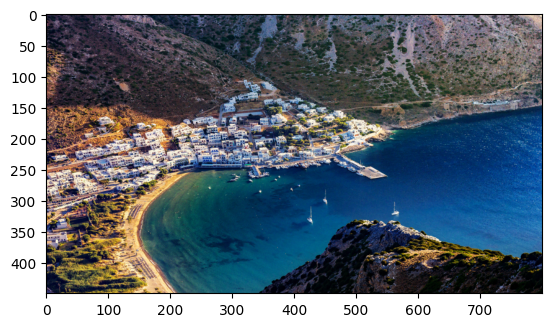

In [5]:
new_image = img.resize((800, 450))
print('data type: ', type(new_image))
plt.imshow(new_image)
plt.show()

PIL --->np.array

In [6]:
image = np.array(new_image)

### 3. Normalize Data

In [6]:
height, width, _ = image.shape
print(image.shape)

# Define functions for data preparation
def normalize_coordinates(y, x, height, width):
    y /= (height - 1)
    x /= (width - 1)
    return y, x

def normalize_color(color):
    return color / 255.0

# Prepare data
def get_item(idx, image, height, width):
    y = idx // width
    x = idx % width

    color = image[y, x]

    # Normalizing
    y, x = normalize_coordinates(y, x, height, width)
    color = normalize_color(color)

    return torch.tensor([y, x], dtype=torch.float32), torch.tensor(color, dtype=torch.float32)

# Load dataset
dataset = [(get_item(idx, image, height, width)) for idx in range(height * width)]
dataset

(450, 800, 3)


[(tensor([0., 0.]), tensor([0.0000, 0.0157, 0.1294])),
 (tensor([0.0000, 0.0013]), tensor([0.0000, 0.0314, 0.1412])),
 (tensor([0.0000, 0.0025]), tensor([0.0039, 0.0510, 0.1412])),
 (tensor([0.0000, 0.0038]), tensor([0.0078, 0.0863, 0.1569])),
 (tensor([0.0000, 0.0050]), tensor([0.0196, 0.0980, 0.1725])),
 (tensor([0.0000, 0.0063]), tensor([0.0392, 0.1294, 0.1882])),
 (tensor([0.0000, 0.0075]), tensor([0.0392, 0.1176, 0.1647])),
 (tensor([0.0000, 0.0088]), tensor([0.0588, 0.0980, 0.1725])),
 (tensor([0.0000, 0.0100]), tensor([0.0235, 0.0706, 0.1569])),
 (tensor([0.0000, 0.0113]), tensor([0.0000, 0.0353, 0.1294])),
 (tensor([0.0000, 0.0125]), tensor([0.0039, 0.0392, 0.1373])),
 (tensor([0.0000, 0.0138]), tensor([0.0039, 0.0471, 0.1451])),
 (tensor([0.0000, 0.0150]), tensor([0.0392, 0.0863, 0.1725])),
 (tensor([0.0000, 0.0163]), tensor([0.0784, 0.1098, 0.2039])),
 (tensor([0.0000, 0.0175]), tensor([0.0549, 0.1059, 0.1882])),
 (tensor([0.0000, 0.0188]), tensor([0.0353, 0.0706, 0.1608])),


### 4. Split Data

In [ ]:
train_percentage = 0.8
validation_percentage = 0.2

num_train_samples = int(train_percentage * len(dataset))
num_val_samples = len(dataset) - num_train_samples

train_dataset, val_dataset = random_split(dataset, [num_train_samples, num_val_samples])

### 5. Define Network Model

In [ ]:
model = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 3),
)

### 6. Define Optimizer & Loss function

In [ ]:
criterion = nn.MSELoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.8, momentum= 0.4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


### 7. Train Model

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Example usage:
# for epoch in range(num_epochs):
#     for batch in train_loader:
#         # Training logic here

#     # Validation after each epoch
#     for val_batch in val_loader:
#         # Validation logic here

In [ ]:
n_epochs = 100  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
    if epoch % 3 == 0:
      scheduler.step()
    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        train_loss
        ))

Epoch: 1 	Training Loss: 0.027951
Epoch: 2 	Training Loss: 0.024044
Epoch: 3 	Training Loss: 0.023328
Epoch: 4 	Training Loss: 0.022859
Epoch: 5 	Training Loss: 0.022229
Epoch: 6 	Training Loss: 0.021952
Epoch: 7 	Training Loss: 0.021698
Epoch: 8 	Training Loss: 0.021263
Epoch: 9 	Training Loss: 0.021131
Epoch: 10 	Training Loss: 0.021073
Epoch: 11 	Training Loss: 0.020691
Epoch: 12 	Training Loss: 0.020628
Epoch: 13 	Training Loss: 0.020576
Epoch: 14 	Training Loss: 0.020347
Epoch: 15 	Training Loss: 0.020324
Epoch: 16 	Training Loss: 0.020279
Epoch: 17 	Training Loss: 0.020077
Epoch: 18 	Training Loss: 0.020055
Epoch: 19 	Training Loss: 0.020048
Epoch: 20 	Training Loss: 0.019856
Epoch: 21 	Training Loss: 0.019820
Epoch: 22 	Training Loss: 0.019801
Epoch: 23 	Training Loss: 0.019639
Epoch: 24 	Training Loss: 0.019630
Epoch: 25 	Training Loss: 0.019620
Epoch: 26 	Training Loss: 0.019468
Epoch: 27 	Training Loss: 0.019449
Epoch: 28 	Training Loss: 0.019421
Epoch: 29 	Training Loss: 0.0

In [ ]:
model.eval() # prep model for training

    # monitor training loss
val_loss = 0.0

for data, target in val_loader:
    output = model(data)
    loss = criterion(output, target)
    val_loss += loss.item()*data.size(0)


# print training statistics
# calculate average loss over an epoch
val_loss = val_loss/len(val_loader.dataset)

print('Epoch: {} \tValidation Loss: {:.6f}'.format(
    epoch+1,
    val_loss
    ))

Epoch: 100 	Validation Loss: 0.017768




### 8. Plot Images

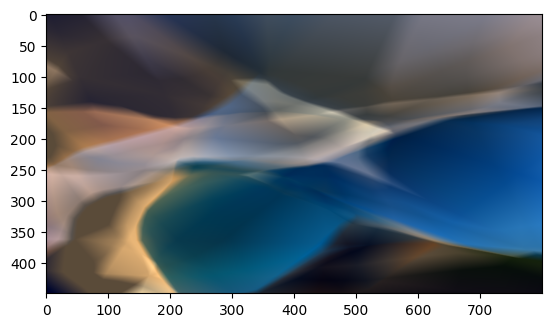

array([[[0.12123126, 0.11821267, 0.19551478],
        [0.12054232, 0.11769357, 0.19542429],
        [0.11985393, 0.11717488, 0.19533388],
        ...,
        [0.6093755 , 0.5620982 , 0.5891926 ],
        [0.6096523 , 0.5623895 , 0.5895877 ],
        [0.6099292 , 0.562681  , 0.58998287]],

       [[0.12309571, 0.11961749, 0.19575965],
        [0.12240934, 0.11910033, 0.19566952],
        [0.12172332, 0.11858343, 0.19557941],
        ...,
        [0.6078147 , 0.5604553 , 0.5869653 ],
        [0.6080916 , 0.56074667, 0.5873604 ],
        [0.60836834, 0.561038  , 0.5877553 ]],

       [[0.12496504, 0.12102599, 0.19600518],
        [0.12427883, 0.12050895, 0.19591504],
        [0.12359257, 0.11999187, 0.19582492],
        ...,
        [0.60625386, 0.5588124 , 0.5847378 ],
        [0.60653067, 0.55910367, 0.5851327 ],
        [0.60680753, 0.55939513, 0.5855279 ]],

       ...,

       [[0.        , 0.        , 0.17229617],
        [0.        , 0.        , 0.17307466],
        [0.        , 0

In [ ]:
full_image = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
model.eval
for data, target in full_image:
    output = model(data)
full_image2 = output.detach().numpy()
full_image3 = np.reshape(full_image2,(450,800,3))
full_image3=np.clip(full_image3,0,255)
plt.figure()
plt.imshow(full_image3)
plt.show()
full_image3

In [ ]:
output.shape

torch.Size([360000, 3])



### 9. Change Layer

In [ ]:
train_percentage = 0.8
validation_percentage = 0.2

num_train_samples = int(train_percentage * len(dataset))
num_val_samples = len(dataset) - num_train_samples

train_dataset, val_dataset = random_split(dataset, [num_train_samples, num_val_samples])

In [ ]:
model = nn.Sequential(
    nn.Linear(2, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 3),
)

In [ ]:
criterion = nn.MSELoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.8, momentum= 0.4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Example usage:
# for epoch in range(num_epochs):
#     for batch in train_loader:
#         # Training logic here

#     # Validation after each epoch
#     for val_batch in val_loader:
#         # Validation logic here

In [ ]:
n_epochs = 100  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
    if epoch % 3 == 0:
      scheduler.step()
    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        train_loss
        ))

Epoch: 1 	Training Loss: 0.027409
Epoch: 2 	Training Loss: 0.023405
Epoch: 3 	Training Loss: 0.022513
Epoch: 4 	Training Loss: 0.021978
Epoch: 5 	Training Loss: 0.021441
Epoch: 6 	Training Loss: 0.021169
Epoch: 7 	Training Loss: 0.020995
Epoch: 8 	Training Loss: 0.020594
Epoch: 9 	Training Loss: 0.020535
Epoch: 10 	Training Loss: 0.020478
Epoch: 11 	Training Loss: 0.020062
Epoch: 12 	Training Loss: 0.019967
Epoch: 13 	Training Loss: 0.019922
Epoch: 14 	Training Loss: 0.019656
Epoch: 15 	Training Loss: 0.019630
Epoch: 16 	Training Loss: 0.019536
Epoch: 17 	Training Loss: 0.019304
Epoch: 18 	Training Loss: 0.019275
Epoch: 19 	Training Loss: 0.019238
Epoch: 20 	Training Loss: 0.019001
Epoch: 21 	Training Loss: 0.019001
Epoch: 22 	Training Loss: 0.018963
Epoch: 23 	Training Loss: 0.018733
Epoch: 24 	Training Loss: 0.018698
Epoch: 25 	Training Loss: 0.018671
Epoch: 26 	Training Loss: 0.018493
Epoch: 27 	Training Loss: 0.018482
Epoch: 28 	Training Loss: 0.018448
Epoch: 29 	Training Loss: 0.0

In [ ]:
model.eval() # prep model for training

    # monitor training loss
val_loss = 0.0

for data, target in val_loader:
    output = model(data)
    loss = criterion(output, target)
    val_loss += loss.item()*data.size(0)


# print training statistics
# calculate average loss over an epoch
val_loss = val_loss/len(val_loader.dataset)

print('Epoch: {} \tValidation Loss: {:.6f}'.format(
    epoch+1,
    val_loss
    ))

Epoch: 100 	Validation Loss: 0.016036


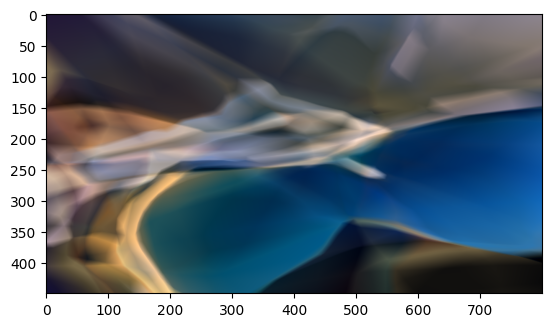

array([[[0.1304906 , 0.08542827, 0.21872476],
        [0.13051462, 0.08570576, 0.21876578],
        [0.13054016, 0.08598766, 0.21881054],
        ...,
        [0.5537197 , 0.52231723, 0.5665879 ],
        [0.55403537, 0.52255684, 0.56669015],
        [0.55435103, 0.52279645, 0.5667926 ]],

       [[0.13106346, 0.08625051, 0.21867839],
        [0.1310888 , 0.08653229, 0.21872312],
        [0.13111451, 0.08681431, 0.21876799],
        ...,
        [0.5531089 , 0.52147996, 0.56440866],
        [0.55342484, 0.5217198 , 0.5645112 ],
        [0.55374056, 0.5219595 , 0.5646136 ]],

       [[0.13163787, 0.08707726, 0.21863595],
        [0.1316632 , 0.08735892, 0.21868065],
        [0.13168857, 0.08764073, 0.21872538],
        ...,
        [0.5524985 , 0.5206431 , 0.56222975],
        [0.55281407, 0.52088267, 0.56233203],
        [0.55313   , 0.52112246, 0.56243455]],

       ...,

       [[0.07442716, 0.05858332, 0.2181499 ],
        [0.07481453, 0.05904901, 0.21640638],
        [0.07520157, 0

In [ ]:
full_image = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
model.eval
for data, target in full_image:
    output = model(data)
full_image2 = output.detach().numpy()
full_image3 = np.reshape(full_image2,(450,800,3))
full_image3=np.clip(full_image3,0,255)
plt.figure()
plt.imshow(full_image3)
plt.show()
full_image3



### 10. Change Units Number

In [ ]:
train_percentage = 0.8
validation_percentage = 0.2

num_train_samples = int(train_percentage * len(dataset))
num_val_samples = len(dataset) - num_train_samples

train_dataset, val_dataset = random_split(dataset, [num_train_samples, num_val_samples])

In [ ]:
model = nn.Sequential(
    nn.Linear(2, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 3),
)

In [ ]:
criterion = nn.MSELoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.8, momentum= 0.4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Example usage:
# for epoch in range(num_epochs):
#     for batch in train_loader:
#         # Training logic here

#     # Validation after each epoch
#     for val_batch in val_loader:
#         # Validation logic here

In [ ]:
n_epochs = 100  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
    if epoch % 3 == 0:
      scheduler.step()
    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        train_loss
        ))

Epoch: 1 	Training Loss: 0.026896
Epoch: 2 	Training Loss: 0.022728
Epoch: 3 	Training Loss: 0.022133
Epoch: 4 	Training Loss: 0.021804
Epoch: 5 	Training Loss: 0.021213
Epoch: 6 	Training Loss: 0.020865
Epoch: 7 	Training Loss: 0.020713
Epoch: 8 	Training Loss: 0.020242
Epoch: 9 	Training Loss: 0.020154
Epoch: 10 	Training Loss: 0.020039
Epoch: 11 	Training Loss: 0.019670
Epoch: 12 	Training Loss: 0.019585
Epoch: 13 	Training Loss: 0.019475
Epoch: 14 	Training Loss: 0.019169
Epoch: 15 	Training Loss: 0.019103
Epoch: 16 	Training Loss: 0.019059
Epoch: 17 	Training Loss: 0.018765
Epoch: 18 	Training Loss: 0.018694
Epoch: 19 	Training Loss: 0.018689
Epoch: 20 	Training Loss: 0.018413
Epoch: 21 	Training Loss: 0.018379
Epoch: 22 	Training Loss: 0.018326
Epoch: 23 	Training Loss: 0.018103
Epoch: 24 	Training Loss: 0.018056
Epoch: 25 	Training Loss: 0.018012
Epoch: 26 	Training Loss: 0.017799
Epoch: 27 	Training Loss: 0.017799
Epoch: 28 	Training Loss: 0.017767
Epoch: 29 	Training Loss: 0.0

In [ ]:
model.eval() # prep model for training

    # monitor training loss
val_loss = 0.0

for data, target in val_loader:
    output = model(data)
    loss = criterion(output, target)
    val_loss += loss.item()*data.size(0)


# print training statistics
# calculate average loss over an epoch
val_loss = val_loss/len(val_loader.dataset)

print('Epoch: {} \tValidation Loss: {:.6f}'.format(
    epoch+1,
    val_loss
    ))


Epoch: 100 	Validation Loss: 0.014809


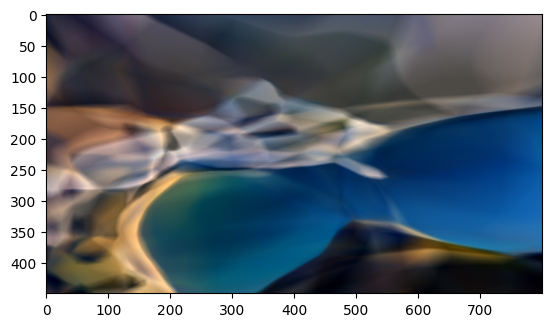

array([[[1.16667405e-01, 1.38593107e-01, 2.24500626e-01],
        [1.21844336e-01, 1.42305434e-01, 2.27315038e-01],
        [1.27021655e-01, 1.46018282e-01, 2.30129927e-01],
        ...,
        [6.00619316e-01, 5.49676657e-01, 5.70882082e-01],
        [6.01520658e-01, 5.50346494e-01, 5.71338892e-01],
        [6.02421939e-01, 5.51016390e-01, 5.71795702e-01]],

       [[1.16444066e-01, 1.38080060e-01, 2.23603725e-01],
        [1.21621162e-01, 1.41792655e-01, 2.26418376e-01],
        [1.26798064e-01, 1.45505071e-01, 2.29232833e-01],
        ...,
        [5.99272966e-01, 5.48363686e-01, 5.69017649e-01],
        [6.00174189e-01, 5.49033463e-01, 5.69474339e-01],
        [6.01075411e-01, 5.49703240e-01, 5.69931030e-01]],

       [[1.16220444e-01, 1.37566924e-01, 2.22706765e-01],
        [1.21397316e-01, 1.41279325e-01, 2.25521237e-01],
        [1.26574636e-01, 1.44992039e-01, 2.28335992e-01],
        ...,
        [5.97926259e-01, 5.47050476e-01, 5.67153037e-01],
        [5.98827600e-01, 5.47

In [ ]:
full_image = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
model.eval
for data, target in full_image:
    output = model(data)
full_image2 = output.detach().numpy()
full_image3 = np.reshape(full_image2,(450,800,3))
full_image3=np.clip(full_image3,0,255)
plt.figure()
plt.imshow(full_image3)
plt.show()
full_image3

#  ***Question 2 : Change Batch Size***



### 1. batch_size = 64


In [ ]:
train_percentage = 0.8
validation_percentage = 0.2

num_train_samples = int(train_percentage * len(dataset))
num_val_samples = len(dataset) - num_train_samples

train_dataset, val_dataset = random_split(dataset, [num_train_samples, num_val_samples])

In [ ]:
model = nn.Sequential(
    nn.Linear(2, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 3),
)

In [ ]:
criterion = nn.MSELoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.8, momentum= 0.4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [ ]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Example usage:
# for epoch in range(num_epochs):
#     for batch in train_loader:
#         # Training logic here

#     # Validation after each epoch
#     for val_batch in val_loader:
#         # Validation logic here

In [ ]:
n_epochs = 100  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
    if epoch % 3 == 0:
      scheduler.step()
    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        train_loss
        ))

Epoch: 1 	Training Loss: 0.027505
Epoch: 2 	Training Loss: 0.022798
Epoch: 3 	Training Loss: 0.021831
Epoch: 4 	Training Loss: 0.021340
Epoch: 5 	Training Loss: 0.020761
Epoch: 6 	Training Loss: 0.020542
Epoch: 7 	Training Loss: 0.020435
Epoch: 8 	Training Loss: 0.020068
Epoch: 9 	Training Loss: 0.019929
Epoch: 10 	Training Loss: 0.019820
Epoch: 11 	Training Loss: 0.019545
Epoch: 12 	Training Loss: 0.019472
Epoch: 13 	Training Loss: 0.019395
Epoch: 14 	Training Loss: 0.019182
Epoch: 15 	Training Loss: 0.019075
Epoch: 16 	Training Loss: 0.019031
Epoch: 17 	Training Loss: 0.018815
Epoch: 18 	Training Loss: 0.018780
Epoch: 19 	Training Loss: 0.018730
Epoch: 20 	Training Loss: 0.018485
Epoch: 21 	Training Loss: 0.018467
Epoch: 22 	Training Loss: 0.018422
Epoch: 23 	Training Loss: 0.018235
Epoch: 24 	Training Loss: 0.018204
Epoch: 25 	Training Loss: 0.018194
Epoch: 26 	Training Loss: 0.017997
Epoch: 27 	Training Loss: 0.017983
Epoch: 28 	Training Loss: 0.017941
Epoch: 29 	Training Loss: 0.0

In [ ]:
model.eval() # prep model for training

    # monitor training loss
val_loss = 0.0

for data, target in val_loader:
    output = model(data)
    loss = criterion(output, target)
    val_loss += loss.item()*data.size(0)


# print training statistics
# calculate average loss over an epoch
val_loss = val_loss/len(val_loader.dataset)

print('Epoch: {} \tValidation Loss: {:.6f}'.format(
    epoch+1,
    val_loss
    ))

Epoch: 100 	Validation Loss: 0.015515


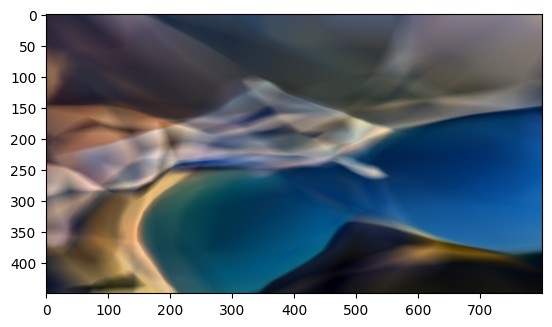

array([[[0.16762337, 0.14850071, 0.22667387],
        [0.16986057, 0.15010968, 0.2280145 ],
        [0.17092845, 0.15103543, 0.2287915 ],
        ...,
        [0.6393445 , 0.57846355, 0.5664785 ],
        [0.64170295, 0.5802802 , 0.56655395],
        [0.6440288 , 0.58207345, 0.5666286 ]],

       [[0.16847828, 0.14886418, 0.2265206 ],
        [0.17071548, 0.1504732 , 0.22785994],
        [0.17295322, 0.15208232, 0.2291995 ],
        ...,
        [0.63696295, 0.5769719 , 0.5651171 ],
        [0.6393217 , 0.57878864, 0.5651926 ],
        [0.6415671 , 0.58044887, 0.56507015]],

       [[0.16933319, 0.14922765, 0.2263661 ],
        [0.17157081, 0.15083686, 0.22770563],
        [0.17380837, 0.15244582, 0.22904506],
        ...,
        [0.6345809 , 0.57547975, 0.5637558 ],
        [0.636662  , 0.5769527 , 0.56352854],
        [0.6380862 , 0.57767403, 0.5627613 ]],

       ...,

       [[0.05832615, 0.07729177, 0.17431188],
        [0.06165594, 0.08018534, 0.17587857],
        [0.06498574, 0

In [ ]:
full_image = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
model.eval
for data, target in full_image:
    output = model(data)
full_image2 = output.detach().numpy()
full_image3 = np.reshape(full_image2,(450,800,3))
full_image3=np.clip(full_image3,0,255)
plt.figure()
plt.imshow(full_image3)
plt.show()
full_image3



### 2. batch_size = 128


In [ ]:
train_percentage = 0.8
validation_percentage = 0.2

num_train_samples = int(train_percentage * len(dataset))
num_val_samples = len(dataset) - num_train_samples

train_dataset, val_dataset = random_split(dataset, [num_train_samples, num_val_samples])

In [ ]:
model = nn.Sequential(
    nn.Linear(2, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 3),
)

In [ ]:
criterion = nn.MSELoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.8, momentum= 0.4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [ ]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Example usage:
# for epoch in range(num_epochs):
#     for batch in train_loader:
#         # Training logic here

#     # Validation after each epoch
#     for val_batch in val_loader:
#         # Validation logic here

In [ ]:
n_epochs = 100  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
    if epoch % 3 == 0:
      scheduler.step()
    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        train_loss
        ))

Epoch: 1 	Training Loss: 0.028964
Epoch: 2 	Training Loss: 0.023089
Epoch: 3 	Training Loss: 0.021873
Epoch: 4 	Training Loss: 0.021179
Epoch: 5 	Training Loss: 0.020625
Epoch: 6 	Training Loss: 0.020332
Epoch: 7 	Training Loss: 0.020143
Epoch: 8 	Training Loss: 0.019814
Epoch: 9 	Training Loss: 0.019710
Epoch: 10 	Training Loss: 0.019602
Epoch: 11 	Training Loss: 0.019367
Epoch: 12 	Training Loss: 0.019314
Epoch: 13 	Training Loss: 0.019232
Epoch: 14 	Training Loss: 0.018998
Epoch: 15 	Training Loss: 0.018940
Epoch: 16 	Training Loss: 0.018918
Epoch: 17 	Training Loss: 0.018732
Epoch: 18 	Training Loss: 0.018654
Epoch: 19 	Training Loss: 0.018657
Epoch: 20 	Training Loss: 0.018470
Epoch: 21 	Training Loss: 0.018421
Epoch: 22 	Training Loss: 0.018371
Epoch: 23 	Training Loss: 0.018215
Epoch: 24 	Training Loss: 0.018202
Epoch: 25 	Training Loss: 0.018136
Epoch: 26 	Training Loss: 0.018000
Epoch: 27 	Training Loss: 0.017954
Epoch: 28 	Training Loss: 0.017945
Epoch: 29 	Training Loss: 0.0

In [ ]:
model.eval() # prep model for training

    # monitor training loss
val_loss = 0.0

for data, target in val_loader:
    output = model(data)
    loss = criterion(output, target)
    val_loss += loss.item()*data.size(0)


# print training statistics
# calculate average loss over an epoch
val_loss = val_loss/len(val_loader.dataset)

print('Epoch: {} \tValidation Loss: {:.6f}'.format(
    epoch+1,
    val_loss
    ))

Epoch: 100 	Validation Loss: 0.016081


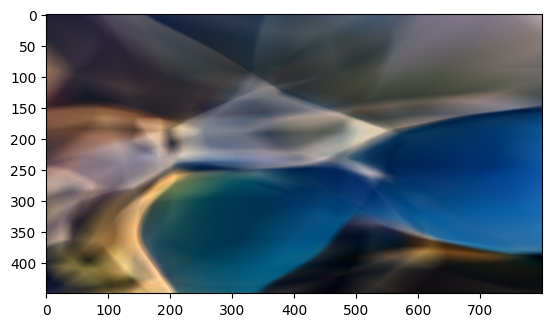

array([[[0.12575671, 0.125005  , 0.19792601],
        [0.12627465, 0.12520084, 0.19852439],
        [0.12679291, 0.12539673, 0.19912286],
        ...,
        [0.72966385, 0.66177607, 0.6769987 ],
        [0.7330203 , 0.6646304 , 0.679415  ],
        [0.7361382 , 0.66725266, 0.68170965]],

       [[0.12659335, 0.12584907, 0.19799262],
        [0.12710455, 0.1260426 , 0.19858845],
        [0.12761724, 0.12623727, 0.19918616],
        ...,
        [0.72447443, 0.657313  , 0.6717185 ],
        [0.7277632 , 0.6601004 , 0.6741054 ],
        [0.7308614 , 0.6627039 , 0.6763718 ]],

       [[0.12743896, 0.12669647, 0.19806328],
        [0.12794453, 0.12688619, 0.19865341],
        [0.12845746, 0.12708086, 0.19925115],
        ...,
        [0.7191373 , 0.652718  , 0.6662587 ],
        [0.72229743, 0.65537935, 0.6685517 ],
        [0.72540617, 0.65799075, 0.67081827]],

       ...,

       [[0.11764351, 0.11964649, 0.2632055 ],
        [0.11485246, 0.12021816, 0.2618654 ],
        [0.11206189, 0

In [ ]:
full_image = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
model.eval
for data, target in full_image:
    output = model(data)
full_image2 = output.detach().numpy()
full_image3 = np.reshape(full_image2,(450,800,3))
full_image3=np.clip(full_image3,0,255)
plt.figure()
plt.imshow(full_image3)
plt.show()
full_image3

#  ***Question 3***
 $𝛾(𝑥) = [ \sin(2^0\pi x), \cos(2^0\pi x), \ldots, \sin(2^{L-1}\pi x), \cos(2^{L-1}\pi x) ]
$


### 1. L = 2

In [7]:
L = 2
height, width, _ = image.shape
print(image.shape)

# Define functions for data preparation
def normalize_coordinates_L(y, x, height, width):
    y /= (height - 1)
    x /= (width - 1)
    return y*2-1, x*2-1

def normalize_color(color):
    return color / 255.0

# Prepare data
def get_item(idx, image, height, width,L):
    y = idx // width
    x = idx % width
    color = image[y, x]

    # Normalizing
    y, x = normalize_coordinates_L(y, x, height, width)
    color = normalize_color(color)
    data_L_y = []
    data_L_x = []
    for l in range (L):
      data_L_y.append(np.sin(2**l*np.pi*y))
      data_L_y.append(np.cos(2**l*np.pi*y))
      data_L_x.append(np.sin(2**l*np.pi*x))
      data_L_x.append(np.cos(2**l*np.pi*x))
    data_L= data_L_y + data_L_x
    return torch.tensor(data_L, dtype=torch.float32), torch.tensor(color, dtype=torch.float32)

# Load dataset
dataset = [(get_item(idx, image, height, width,L)) for idx in range(height * width)]
dataset

(450, 800, 3)


[(tensor([-1.2246e-16, -1.0000e+00,  2.4493e-16,  1.0000e+00, -1.2246e-16,
          -1.0000e+00,  2.4493e-16,  1.0000e+00]),
  tensor([0.0000, 0.0157, 0.1294])),
 (tensor([-1.2246e-16, -1.0000e+00,  2.4493e-16,  1.0000e+00, -7.8637e-03,
          -9.9997e-01,  1.5727e-02,  9.9988e-01]),
  tensor([0.0000, 0.0314, 0.1412])),
 (tensor([-1.2246e-16, -1.0000e+00,  2.4493e-16,  1.0000e+00, -1.5727e-02,
          -9.9988e-01,  3.1450e-02,  9.9951e-01]),
  tensor([0.0039, 0.0510, 0.1412])),
 (tensor([-1.2246e-16, -1.0000e+00,  2.4493e-16,  1.0000e+00, -2.3589e-02,
          -9.9972e-01,  4.7165e-02,  9.9889e-01]),
  tensor([0.0078, 0.0863, 0.1569])),
 (tensor([-1.2246e-16, -1.0000e+00,  2.4493e-16,  1.0000e+00, -3.1450e-02,
          -9.9951e-01,  6.2869e-02,  9.9802e-01]),
  tensor([0.0196, 0.0980, 0.1725])),
 (tensor([-1.2246e-16, -1.0000e+00,  2.4493e-16,  1.0000e+00, -3.9309e-02,
          -9.9923e-01,  7.8557e-02,  9.9691e-01]),
  tensor([0.0392, 0.1294, 0.1882])),
 (tensor([-1.2246e-16,

In [8]:
train_percentage = 0.8
validation_percentage = 0.2

num_train_samples = int(train_percentage * len(dataset))
num_val_samples = len(dataset) - num_train_samples

train_dataset, val_dataset = random_split(dataset, [num_train_samples, num_val_samples])

In [9]:
model = nn.Sequential(
    nn.Linear(4*L, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 3),
)

In [10]:
criterion = nn.MSELoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.8, momentum= 0.4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [11]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Example usage:
# for epoch in range(num_epochs):
#     for batch in train_loader:
#         # Training logic here

#     # Validation after each epoch
#     for val_batch in val_loader:
#         # Validation logic here

In [12]:
n_epochs = 100  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
    if epoch % 3 == 0:
      scheduler.step()
    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        train_loss
        ))

Epoch: 1 	Training Loss: 0.021485
Epoch: 2 	Training Loss: 0.018736
Epoch: 3 	Training Loss: 0.017995
Epoch: 4 	Training Loss: 0.017560
Epoch: 5 	Training Loss: 0.016980
Epoch: 6 	Training Loss: 0.016679
Epoch: 7 	Training Loss: 0.016486
Epoch: 8 	Training Loss: 0.016050
Epoch: 9 	Training Loss: 0.015885
Epoch: 10 	Training Loss: 0.015769
Epoch: 11 	Training Loss: 0.015439
Epoch: 12 	Training Loss: 0.015271
Epoch: 13 	Training Loss: 0.015182
Epoch: 14 	Training Loss: 0.014916
Epoch: 15 	Training Loss: 0.014799
Epoch: 16 	Training Loss: 0.014720
Epoch: 17 	Training Loss: 0.014417
Epoch: 18 	Training Loss: 0.014380
Epoch: 19 	Training Loss: 0.014312
Epoch: 20 	Training Loss: 0.014058
Epoch: 21 	Training Loss: 0.013999
Epoch: 22 	Training Loss: 0.013942
Epoch: 23 	Training Loss: 0.013712
Epoch: 24 	Training Loss: 0.013694
Epoch: 25 	Training Loss: 0.013633
Epoch: 26 	Training Loss: 0.013420
Epoch: 27 	Training Loss: 0.013359
Epoch: 28 	Training Loss: 0.013294
Epoch: 29 	Training Loss: 0.0

In [13]:
model.eval() # prep model for training

    # monitor training loss
val_loss = 0.0

for data, target in val_loader:
    output = model(data)
    loss = criterion(output, target)
    val_loss += loss.item()*data.size(0)


# print training statistics
# calculate average loss over an epoch
val_loss = val_loss/len(val_loader.dataset)

print('Epoch: {} \tValidation Loss: {:.6f}'.format(
    epoch+1,
    val_loss
    ))

Epoch: 100 	Validation Loss: 0.010573


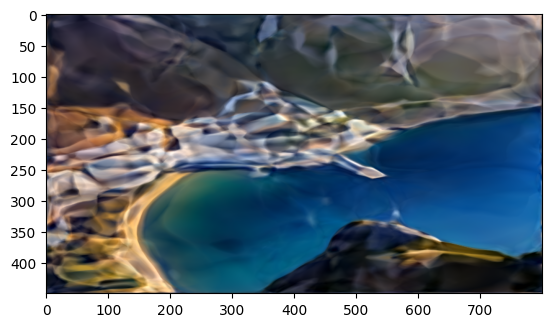

array([[[0.31509995, 0.3228799 , 0.39314753],
        [0.1994083 , 0.22698289, 0.3269649 ],
        [0.1405301 , 0.17955883, 0.29554176],
        ...,
        [0.4567405 , 0.43356022, 0.46470106],
        [0.39764795, 0.38690835, 0.4321422 ],
        [0.31509995, 0.3228799 , 0.39314753]],

       [[0.52204794, 0.4899315 , 0.5467289 ],
        [0.268742  , 0.2800511 , 0.37808686],
        [0.09471467, 0.1366508 , 0.25314102],
        ...,
        [0.8205344 , 0.7459942 , 0.7312137 ],
        [0.7215028 , 0.6564599 , 0.6647238 ],
        [0.52204794, 0.4899315 , 0.5467289 ]],

       [[0.6347536 , 0.57611907, 0.5975602 ],
        [0.336433  , 0.32558975, 0.41359237],
        [0.18491831, 0.20905897, 0.31446287],
        ...,
        [0.8510127 , 0.77104414, 0.736418  ],
        [0.77282023, 0.6987692 , 0.68347985],
        [0.6347536 , 0.57611907, 0.5975602 ]],

       ...,

       [[0.10138342, 0.13900602, 0.24367061],
        [0.13082582, 0.16817908, 0.2800717 ],
        [0.1542489 , 0

In [14]:
full_image = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
model.eval
for data, target in full_image:
    output = model(data)
full_image2 = output.detach().numpy()
full_image3 = np.reshape(full_image2,(450,800,3))
full_image3=np.clip(full_image3,0,255)
plt.figure()
plt.imshow(full_image3)
plt.show()
full_image3

### 2. L = 4

In [ ]:
L = 4
height, width, _ = image.shape
print(image.shape)

# Define functions for data preparation
def normalize_coordinates_L(y, x, height, width):
    y /= (height - 1)
    x /= (width - 1)
    return y*2-1, x*2-1

def normalize_color(color):
    return color / 255.0

# Prepare data
def get_item(idx, image, height, width,L):
    y = idx // width
    x = idx % width
    color = image[y, x]

    # Normalizing
    y, x = normalize_coordinates_L(y, x, height, width)
    color = normalize_color(color)
    data_L_y = []
    data_L_x = []
    for l in range (L):
      data_L_y.append(np.sin(2**l*np.pi*y))
      data_L_y.append(np.cos(2**l*np.pi*y))
      data_L_x.append(np.sin(2**l*np.pi*x))
      data_L_x.append(np.cos(2**l*np.pi*x))
    data_L= data_L_y + data_L_x
    return torch.tensor(data_L, dtype=torch.float32), torch.tensor(color, dtype=torch.float32)

# Load dataset
dataset = [(get_item(idx, image, height, width,L)) for idx in range(height * width)]
dataset

In [ ]:
train_percentage = 0.8
validation_percentage = 0.2

num_train_samples = int(train_percentage * len(dataset))
num_val_samples = len(dataset) - num_train_samples

train_dataset, val_dataset = random_split(dataset, [num_train_samples, num_val_samples])

In [ ]:
model = nn.Sequential(
    nn.Linear(4*L, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 3),
)

In [ ]:
criterion = nn.MSELoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.8, momentum= 0.4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Example usage:
# for epoch in range(num_epochs):
#     for batch in train_loader:
#         # Training logic here

#     # Validation after each epoch
#     for val_batch in val_loader:
#         # Validation logic here

In [ ]:
n_epochs = 100  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
    if epoch % 3 == 0:
      scheduler.step()
    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        train_loss
        ))

In [ ]:
model.eval() # prep model for training

    # monitor training loss
val_loss = 0.0

for data, target in val_loader:
    output = model(data)
    loss = criterion(output, target)
    val_loss += loss.item()*data.size(0)


# print training statistics
# calculate average loss over an epoch
val_loss = val_loss/len(val_loader.dataset)

print('Epoch: {} \tValidation Loss: {:.6f}'.format(
    epoch+1,
    val_loss
    ))

In [ ]:
full_image = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
model.eval
for data, target in full_image:
    output = model(data)
full_image2 = output.detach().numpy()
full_image3 = np.reshape(full_image2,(450,800,3))
full_image3=np.clip(full_image3,0,255)
plt.figure()
plt.imshow(full_image3)
plt.show()
full_image3

### 3. L = 6

In [ ]:
L = 6
height, width, _ = image.shape
print(image.shape)

# Define functions for data preparation
def normalize_coordinates_L(y, x, height, width):
    y /= (height - 1)
    x /= (width - 1)
    return y*2-1, x*2-1

def normalize_color(color):
    return color / 255.0

# Prepare data
def get_item(idx, image, height, width,L):
    y = idx // width
    x = idx % width
    color = image[y, x]

    # Normalizing
    y, x = normalize_coordinates_L(y, x, height, width)
    color = normalize_color(color)
    data_L_y = []
    data_L_x = []
    for l in range (L):
      data_L_y.append(np.sin(2**l*np.pi*y))
      data_L_y.append(np.cos(2**l*np.pi*y))
      data_L_x.append(np.sin(2**l*np.pi*x))
      data_L_x.append(np.cos(2**l*np.pi*x))
    data_L= data_L_y + data_L_x
    return torch.tensor(data_L, dtype=torch.float32), torch.tensor(color, dtype=torch.float32)

# Load dataset
dataset = [(get_item(idx, image, height, width,L)) for idx in range(height * width)]
dataset

In [ ]:
train_percentage = 0.8
validation_percentage = 0.2

num_train_samples = int(train_percentage * len(dataset))
num_val_samples = len(dataset) - num_train_samples

train_dataset, val_dataset = random_split(dataset, [num_train_samples, num_val_samples])

In [ ]:
model = nn.Sequential(
    nn.Linear(4*L, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 3),
)

In [ ]:
criterion = nn.MSELoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.8, momentum= 0.4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Example usage:
# for epoch in range(num_epochs):
#     for batch in train_loader:
#         # Training logic here

#     # Validation after each epoch
#     for val_batch in val_loader:
#         # Validation logic here

In [ ]:
n_epochs = 100  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
    if epoch % 3 == 0:
      scheduler.step()
    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        train_loss
        ))

In [ ]:
model.eval() # prep model for training

    # monitor training loss
val_loss = 0.0

for data, target in val_loader:
    output = model(data)
    loss = criterion(output, target)
    val_loss += loss.item()*data.size(0)


# print training statistics
# calculate average loss over an epoch
val_loss = val_loss/len(val_loader.dataset)

print('Epoch: {} \tValidation Loss: {:.6f}'.format(
    epoch+1,
    val_loss
    ))

In [ ]:
full_image = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
model.eval
for data, target in full_image:
    output = model(data)
full_image2 = output.detach().numpy()
full_image3 = np.reshape(full_image2,(450,800,3))
full_image3=np.clip(full_image3,0,255)
plt.figure()
plt.imshow(full_image3)
plt.show()
full_image3

### 4. L = 8

In [ ]:
L = 8
height, width, _ = image.shape
print(image.shape)

# Define functions for data preparation
def normalize_coordinates_L(y, x, height, width):
    y /= (height - 1)
    x /= (width - 1)
    return y*2-1, x*2-1

def normalize_color(color):
    return color / 255.0

# Prepare data
def get_item(idx, image, height, width,L):
    y = idx // width
    x = idx % width
    color = image[y, x]

    # Normalizing
    y, x = normalize_coordinates_L(y, x, height, width)
    color = normalize_color(color)
    data_L_y = []
    data_L_x = []
    for l in range (L):
      data_L_y.append(np.sin(2**l*np.pi*y))
      data_L_y.append(np.cos(2**l*np.pi*y))
      data_L_x.append(np.sin(2**l*np.pi*x))
      data_L_x.append(np.cos(2**l*np.pi*x))
    data_L= data_L_y + data_L_x
    return torch.tensor(data_L, dtype=torch.float32), torch.tensor(color, dtype=torch.float32)

# Load dataset
dataset = [(get_item(idx, image, height, width,L)) for idx in range(height * width)]
dataset

In [ ]:
train_percentage = 0.8
validation_percentage = 0.2

num_train_samples = int(train_percentage * len(dataset))
num_val_samples = len(dataset) - num_train_samples

train_dataset, val_dataset = random_split(dataset, [num_train_samples, num_val_samples])

In [ ]:
model = nn.Sequential(
    nn.Linear(4*L, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 3),
)

In [ ]:
criterion = nn.MSELoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.8, momentum= 0.4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Example usage:
# for epoch in range(num_epochs):
#     for batch in train_loader:
#         # Training logic here

#     # Validation after each epoch
#     for val_batch in val_loader:
#         # Validation logic here

In [ ]:
n_epochs = 100  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
    if epoch % 3 == 0:
      scheduler.step()
    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        train_loss
        ))

In [ ]:
model.eval() # prep model for training

    # monitor training loss
val_loss = 0.0

for data, target in val_loader:
    output = model(data)
    loss = criterion(output, target)
    val_loss += loss.item()*data.size(0)


# print training statistics
# calculate average loss over an epoch
val_loss = val_loss/len(val_loader.dataset)

print('Epoch: {} \tValidation Loss: {:.6f}'.format(
    epoch+1,
    val_loss
    ))

In [ ]:
full_image = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
model.eval
for data, target in full_image:
    output = model(data)
full_image2 = output.detach().numpy()
full_image3 = np.reshape(full_image2,(450,800,3))
full_image3=np.clip(full_image3,0,255)
plt.figure()
plt.imshow(full_image3)
plt.show()
full_image3

#  ***Question 6: L-BFGS***



### 1. L = 3

In [14]:
L = 3
height, width, _ = image.shape
print(image.shape)

# Define functions for data preparation
def normalize_coordinates_L(y, x, height, width):
    y /= (height - 1)
    x /= (width - 1)
    return y*2-1, x*2-1

def normalize_color(color):
    return color / 255.0

# Prepare data
def get_item(idx, image, height, width,L):
    y = idx // width
    x = idx % width
    color = image[y, x]

    # Normalizing
    y, x = normalize_coordinates_L(y, x, height, width)
    color = normalize_color(color)
    data_L_y = []
    data_L_x = []
    for l in range (L):
      data_L_y.append(np.sin(2**l*np.pi*y))
      data_L_y.append(np.cos(2**l*np.pi*y))
      data_L_x.append(np.sin(2**l*np.pi*x))
      data_L_x.append(np.cos(2**l*np.pi*x))
    data_L= data_L_y + data_L_x
    return torch.tensor(data_L, dtype=torch.float32), torch.tensor(color, dtype=torch.float32)

# Load dataset
dataset = [(get_item(idx, image, height, width,L)) for idx in range(height * width)]
dataset

(450, 800, 3)


[(tensor([-1.2246e-16, -1.0000e+00,  2.4493e-16,  1.0000e+00,  4.8986e-16,
           1.0000e+00, -1.2246e-16, -1.0000e+00,  2.4493e-16,  1.0000e+00,
           4.8986e-16,  1.0000e+00]),
  tensor([0.0000, 0.0157, 0.1294])),
 (tensor([-1.2246e-16, -1.0000e+00,  2.4493e-16,  1.0000e+00,  4.8986e-16,
           1.0000e+00, -7.8637e-03, -9.9997e-01,  1.5727e-02,  9.9988e-01,
           3.1450e-02,  9.9951e-01]),
  tensor([0.0000, 0.0314, 0.1412])),
 (tensor([-1.2246e-16, -1.0000e+00,  2.4493e-16,  1.0000e+00,  4.8986e-16,
           1.0000e+00, -1.5727e-02, -9.9988e-01,  3.1450e-02,  9.9951e-01,
           6.2869e-02,  9.9802e-01]),
  tensor([0.0039, 0.0510, 0.1412])),
 (tensor([-1.2246e-16, -1.0000e+00,  2.4493e-16,  1.0000e+00,  4.8986e-16,
           1.0000e+00, -2.3589e-02, -9.9972e-01,  4.7165e-02,  9.9889e-01,
           9.4226e-02,  9.9555e-01]),
  tensor([0.0078, 0.0863, 0.1569])),
 (tensor([-1.2246e-16, -1.0000e+00,  2.4493e-16,  1.0000e+00,  4.8986e-16,
           1.0000e+00, -3

In [15]:
train_percentage = 0.8
validation_percentage = 0.2

num_train_samples = int(train_percentage * len(dataset))
num_val_samples = len(dataset) - num_train_samples

train_dataset, val_dataset = random_split(dataset, [num_train_samples, num_val_samples])

In [16]:
model2 = nn.Sequential(
    nn.Linear(4*L, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 3),
)

In [17]:
criterion = nn.MSELoss()

# specify optimizer
optimizer = torch.optim.LBFGS(model2.parameters(), max_iter=20, history_size=40)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [18]:
batch_size = len(dataset)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Example usage:
# for epoch in range(num_epochs):
#     for batch in train_loader:
#         # Training logic here

#     # Validation after each epoch
#     for val_batch in val_loader:
#         # Validation logic here

In [19]:
n_epochs = 100  # suggest training between 20-50 epochs

model2.train() # prep model for training
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    # monitor training loss
    train_loss  = 0.0

    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        def closure():
            if torch.is_grad_enabled():
                optimizer.zero_grad()
            outputs = model2(data.float())
            loss = criterion(outputs, target)
            if loss.requires_grad:
                loss.backward()
            return loss.item()  # Return the loss value, not the loss variable

        # L-BFGS step
        optimizer.step(closure)

       # Calculate the loss for monitoring (do not backpropagate)
        train_loss += closure()
        #print(f'Training Loss: {train_loss}')


       # if batch_idx % 200 == 0:
       #     print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_dataloader)}], Loss: {epoch_loss / (batch_idx + 1):.4f}')

    # Calculate average epoch loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        train_losses[-1]
        ))

Epoch: 1 	Training Loss: 0.028475
Epoch: 2 	Training Loss: 0.021036
Epoch: 3 	Training Loss: 0.018799
Epoch: 4 	Training Loss: 0.017546
Epoch: 5 	Training Loss: 0.016684
Epoch: 6 	Training Loss: 0.016033
Epoch: 7 	Training Loss: 0.015470
Epoch: 8 	Training Loss: 0.015028
Epoch: 9 	Training Loss: 0.014602
Epoch: 10 	Training Loss: 0.014260
Epoch: 11 	Training Loss: 0.013949
Epoch: 12 	Training Loss: 0.013712
Epoch: 13 	Training Loss: 0.013471
Epoch: 14 	Training Loss: 0.013277
Epoch: 15 	Training Loss: 0.013087
Epoch: 16 	Training Loss: 0.012918
Epoch: 17 	Training Loss: 0.012777
Epoch: 18 	Training Loss: 0.012642
Epoch: 19 	Training Loss: 0.012513
Epoch: 20 	Training Loss: 0.012406
Epoch: 21 	Training Loss: 0.012288
Epoch: 22 	Training Loss: 0.012192
Epoch: 23 	Training Loss: 0.012095
Epoch: 24 	Training Loss: 0.012006
Epoch: 25 	Training Loss: 0.011934
Epoch: 26 	Training Loss: 0.011856
Epoch: 27 	Training Loss: 0.011794
Epoch: 28 	Training Loss: 0.011699
Epoch: 29 	Training Loss: 0.0

KeyboardInterrupt: ignored

In [20]:
model2.eval() # prep model for training

    # monitor training loss
val_loss = 0.0

for data, target in val_loader:
    output = model2(data)
    loss = criterion(output, target)
    val_loss += loss.item()*data.size(0)


# print training statistics
# calculate average loss over an epoch
val_loss = val_loss/len(val_loader.dataset)

print('Epoch: {} \tValidation Loss: {:.6f}'.format(
    epoch+1,
    val_loss
    ))

Epoch: 52 	Validation Loss: 0.011160


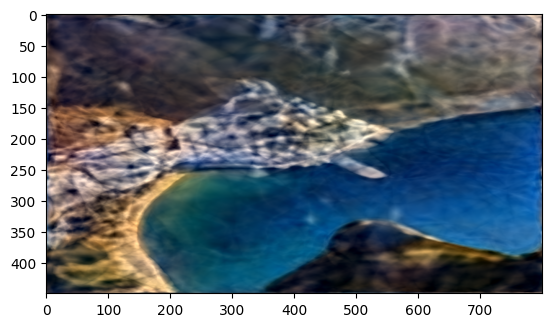

array([[[0.46143335, 0.40902033, 0.40205866],
        [0.32607925, 0.29378137, 0.31175083],
        [0.25059515, 0.23218665, 0.26613927],
        ...,
        [0.5496308 , 0.47756293, 0.44604325],
        [0.5349158 , 0.46876624, 0.44468105],
        [0.46143335, 0.40902033, 0.40205866]],

       [[0.5928029 , 0.5363498 , 0.51451844],
        [0.41014564, 0.37736806, 0.3880244 ],
        [0.24154478, 0.22942707, 0.2696634 ],
        ...,
        [0.76458114, 0.6823243 , 0.62804323],
        [0.70789087, 0.6345445 , 0.5912157 ],
        [0.5928029 , 0.5363498 , 0.51451844]],

       [[0.63797575, 0.5767138 , 0.54819816],
        [0.43230993, 0.3959646 , 0.403368  ],
        [0.23986536, 0.22682777, 0.2676865 ],
        ...,
        [0.84292114, 0.7547766 , 0.68757105],
        [0.78805214, 0.7075716 , 0.6514486 ],
        [0.63797575, 0.5767138 , 0.54819816]],

       ...,

       [[0.21735346, 0.19843438, 0.22807986],
        [0.21608973, 0.20036635, 0.23357546],
        [0.21016979, 0

In [21]:
full_image = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
model2.eval
for data, target in full_image:
    output = model2(data)
full_image2 = output.detach().numpy()
full_image3 = np.reshape(full_image2,(450,800,3))
full_image3=np.clip(full_image3,0,255)
plt.figure()
plt.imshow(full_image3)
plt.show()
full_image3

# 2. L = 5

In [ ]:
L = 5
height, width, _ = image.shape
print(image.shape)

# Define functions for data preparation
def normalize_coordinates_L(y, x, height, width):
    y /= (height - 1)
    x /= (width - 1)
    return y*2-1, x*2-1

def normalize_color(color):
    return color / 255.0

# Prepare data
def get_item(idx, image, height, width,L):
    y = idx // width
    x = idx % width
    color = image[y, x]

    # Normalizing
    y, x = normalize_coordinates_L(y, x, height, width)
    color = normalize_color(color)
    data_L_y = []
    data_L_x = []
    for l in range (L):
      data_L_y.append(np.sin(2**l*np.pi*y))
      data_L_y.append(np.cos(2**l*np.pi*y))
      data_L_x.append(np.sin(2**l*np.pi*x))
      data_L_x.append(np.cos(2**l*np.pi*x))
    data_L= data_L_y + data_L_x
    return torch.tensor(data_L, dtype=torch.float32), torch.tensor(color, dtype=torch.float32)

# Load dataset
dataset = [(get_item(idx, image, height, width,L)) for idx in range(height * width)]
dataset

(450, 800, 3)


[(tensor([-1.2246e-16, -1.0000e+00,  2.4493e-16,  1.0000e+00,  4.8986e-16,
           1.0000e+00, -1.2246e-16, -1.0000e+00,  2.4493e-16,  1.0000e+00,
           4.8986e-16,  1.0000e+00]),
  tensor([0.0000, 0.0157, 0.1294])),
 (tensor([-1.2246e-16, -1.0000e+00,  2.4493e-16,  1.0000e+00,  4.8986e-16,
           1.0000e+00, -7.8637e-03, -9.9997e-01,  1.5727e-02,  9.9988e-01,
           3.1450e-02,  9.9951e-01]),
  tensor([0.0000, 0.0314, 0.1412])),
 (tensor([-1.2246e-16, -1.0000e+00,  2.4493e-16,  1.0000e+00,  4.8986e-16,
           1.0000e+00, -1.5727e-02, -9.9988e-01,  3.1450e-02,  9.9951e-01,
           6.2869e-02,  9.9802e-01]),
  tensor([0.0039, 0.0510, 0.1412])),
 (tensor([-1.2246e-16, -1.0000e+00,  2.4493e-16,  1.0000e+00,  4.8986e-16,
           1.0000e+00, -2.3589e-02, -9.9972e-01,  4.7165e-02,  9.9889e-01,
           9.4226e-02,  9.9555e-01]),
  tensor([0.0078, 0.0863, 0.1569])),
 (tensor([-1.2246e-16, -1.0000e+00,  2.4493e-16,  1.0000e+00,  4.8986e-16,
           1.0000e+00, -3

In [ ]:
train_percentage = 0.8
validation_percentage = 0.2

num_train_samples = int(train_percentage * len(dataset))
num_val_samples = len(dataset) - num_train_samples

train_dataset, val_dataset = random_split(dataset, [num_train_samples, num_val_samples])

In [ ]:
model2 = nn.Sequential(
    nn.Linear(4*L, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 3),
)

In [ ]:
criterion = nn.MSELoss()

# specify optimizer
optimizer = torch.optim.LBFGS(model2.parameters(), max_iter=20, history_size=40)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [ ]:
batch_size = len(dataset)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Example usage:
# for epoch in range(num_epochs):
#     for batch in train_loader:
#         # Training logic here

#     # Validation after each epoch
#     for val_batch in val_loader:
#         # Validation logic here

In [ ]:
n_epochs = 100  # suggest training between 20-50 epochs

model2.train() # prep model for training
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    # monitor training loss
    train_loss  = 0.0

    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        def closure():
            if torch.is_grad_enabled():
                optimizer.zero_grad()
            outputs = model2(data.float())
            loss = criterion(outputs, target)
            if loss.requires_grad:
                loss.backward()
            return loss.item()  # Return the loss value, not the loss variable

        # L-BFGS step
        optimizer.step(closure)

       # Calculate the loss for monitoring (do not backpropagate)
        train_loss += closure()
        #print(f'Training Loss: {train_loss}')


       # if batch_idx % 200 == 0:
       #     print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_dataloader)}], Loss: {epoch_loss / (batch_idx + 1):.4f}')

    # Calculate average epoch loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        train_losses[-1]
        ))

Epoch: 1 	Training Loss: 0.028475
Epoch: 2 	Training Loss: 0.021036
Epoch: 3 	Training Loss: 0.018799
Epoch: 4 	Training Loss: 0.017546
Epoch: 5 	Training Loss: 0.016684
Epoch: 6 	Training Loss: 0.016033
Epoch: 7 	Training Loss: 0.015470
Epoch: 8 	Training Loss: 0.015028
Epoch: 9 	Training Loss: 0.014602
Epoch: 10 	Training Loss: 0.014260
Epoch: 11 	Training Loss: 0.013949
Epoch: 12 	Training Loss: 0.013712
Epoch: 13 	Training Loss: 0.013471
Epoch: 14 	Training Loss: 0.013277
Epoch: 15 	Training Loss: 0.013087
Epoch: 16 	Training Loss: 0.012918
Epoch: 17 	Training Loss: 0.012777
Epoch: 18 	Training Loss: 0.012642
Epoch: 19 	Training Loss: 0.012513
Epoch: 20 	Training Loss: 0.012406
Epoch: 21 	Training Loss: 0.012288
Epoch: 22 	Training Loss: 0.012192
Epoch: 23 	Training Loss: 0.012095
Epoch: 24 	Training Loss: 0.012006
Epoch: 25 	Training Loss: 0.011934
Epoch: 26 	Training Loss: 0.011856
Epoch: 27 	Training Loss: 0.011794
Epoch: 28 	Training Loss: 0.011699
Epoch: 29 	Training Loss: 0.0

In [ ]:
model2.eval() # prep model for training

    # monitor training loss
val_loss = 0.0

for data, target in val_loader:
    output = model2(data)
    loss = criterion(output, target)
    val_loss += loss.item()*data.size(0)


# print training statistics
# calculate average loss over an epoch
val_loss = val_loss/len(val_loader.dataset)

print('Epoch: {} \tValidation Loss: {:.6f}'.format(
    epoch+1,
    val_loss
    ))

In [ ]:
full_image = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
model2.eval
for data, target in full_image:
    output = model2(data)
full_image2 = output.detach().numpy()
full_image3 = np.reshape(full_image2,(450,800,3))
full_image3=np.clip(full_image3,0,255)
plt.figure()
plt.imshow(full_image3)
plt.show()
full_image3

#  ***Question 7***

In [ ]:
Res_image = img.resize((1600, 900))
print('data type: ', type(Res_image))
plt.imshow(Res_image)
plt.show()

PIL --->np.array

In [ ]:
imageR = np.array(Res_image)

In [ ]:
height, width, _ = imageR.shape
print(imageR.shape)

# Define functions for data preparation
def normalize_coordinates(y, x, height, width):
    y /= (height - 1)
    x /= (width - 1)
    return y, x

def normalize_color(color):
    return color / 255.0

# Prepare data
def get_item(idx, imageR, height, width):
    y = idx // width
    x = idx % width

    color = imageR[y, x]

    # Normalizing
    y, x = normalize_coordinates(y, x, height, width)
    color = normalize_color(color)

    return torch.tensor([y, x], dtype=torch.float32), torch.tensor(color, dtype=torch.float32)

# Load dataset
datasetR = [(get_item(idx, imageR, height, width)) for idx in range(height * width)]
datasetR

In [ ]:
model.eval() # prep model for training

    # monitor training loss
val_loss = 0.0

for data, target in val_loader:
    output = model(data)
    loss = criterion(output, target)
    val_loss += loss.item()*data.size(0)


# print training statistics
# calculate average loss over an epoch
val_loss = val_loss/len(val_loader.dataset)

print('Epoch: {} \tValidation Loss: {:.6f}'.format(
    epoch+1,
    val_loss
    ))

In [ ]:
full_image = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
model.eval()
for data, target in full_image:
    output2 = model(data)
full_image2 = output2.detach().numpy()
full_image3 = np.reshape(full_image2,(900,1600,3))
full_image3=np.clip(full_image3,0,255)
plt.figure()
plt.imshow(full_image3)
plt.show()
full_image3

In [ ]:
output.shape